# Can fixing/giving very narrow total stellar mass formed priors solve outshining?
Intriging question. The theory is to provide bagpipes with a very narrow prior of Mstar, preferrably informed by alternative sources for real galaxies, and perhaps this Mstar prior that is much higher than the typical 50% lower Mstar estimate due to outshining can push bagpipes in the right direction and recover more mass formed in the super old stellar population, or at least enlarge some uncertainties. <br>

In [1]:
import numpy as np 
import bagpipes as pipes

from PyAstronomy import pyasl
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,peak_prominences

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
# loading in the true SFH
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

Relevent functions for bagpipes spectrum reading...

In [3]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((int(nbins), spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec

def mask_sky(wave):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    masksize=10
    lines_vac = np.array([5578.5486,4279.2039,6301.7423,6365.7595])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask

def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24,6564.61,6549.8490,6585.2784, 6717., 6731., 5893., 6302.046, 6918.6, 3870.])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        if lines[i] > 6500 and lines[i] < 6600 or lines[i]==5893:
            masksize = 10
        else:
            masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    #ind = np.where(wave<3000)
    #mask.extend(ind[0])    

    return mask

def load_manga_spec_mask(ID, full=True):
    """ Extracts correct spectrum and masks emission lines """
    """ Note redshift, flux etc. are all passed silently!!!!"""
   
    spectrum = np.loadtxt(fname=run_params['spectrum_dir']+
                          "/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
  
    # pixel mask from DAP, not clear if we want to use this or not. Try fort
    #pixmask = (np.where(mask[pix_x,pix_y,:] !=0))[0]
    #spectrum[pixmask, 2] = 9.9*10**99.


    # nebular emission lines and interstellar absorption lines
    linemask = mask_em(spectrum[:,0]/(1+z))
    spectrum[linemask, 2] = 9.9*10**99.
    
    # skylines
    linemask = mask_sky(spectrum[:,0])
    spectrum[linemask, 2] = 9.9*10**99.
  
    for j in range(len(spectrum)):
        if (spectrum[j, 1] == 0) or (spectrum[j, 2] <= 0):
            spectrum[j, 2] = 9.9*10**99.
    
    if full == False:
        endmask = (spectrum[:,0]/(1+z) < 7500) # just miles range
    else:
        endmask = (spectrum[:,0]>0)
    if run_params['bin_by'] == 1:
        return spectrum[endmask]
    else:
        return bin(spectrum[endmask], run_params['bin_by'])

Functions to easily load and plot the posteriors in fancy plots

In [4]:
def process_params(run_params):
    galID = run_params['galID_parts'][0]
    runID = run_params['runID_parts'][0]
    spectrum_dir = run_params['spectrum_dir_root']

    if run_params['PSF']:
        spectrum_dir += 'with_PSF/'
        galID += '_with_PSF'
    else:
        spectrum_dir += 'no_PSF/'
        galID += '_no_PSF'

    if run_params['dust']:
        spectrum_dir += 'with_dust'
        galID += '_with_dust'
        runID += '_with_dust'
    else:
        spectrum_dir += 'no_dust'
        galID += '_no_dust'
        runID += '_no_dust'

    if run_params['noise']:
        galID += '_with_noise'
        runID += '_with_noise'
    else:
        runID += '_no_noise'

    runID += f"_bin_by_{run_params['bin_by']}_{run_params['Rspec']}_Rspec"

    galID += run_params['galID_parts'][1]
    runID += run_params['runID_parts'][1]
    run_params['spectrum_dir'] = spectrum_dir
    run_params['galID'] = galID
    run_params['runID'] = runID
    
    print('setting bagpipes Rspec to '+str(run_params['Rspec']))
    pipes.config.Rspec = run_params['Rspec']
    
    return run_params

def plot_spec2(fit, ID, runID, spec_lim=None, save=True):
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    if spec_lim is not None:
        ax1.set_xlim(spec_lim)
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    if save:
        fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()
    
# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

def cal_f_burst(ages, sfh, print_=True):
    #1. find_peaks (ignoring age) with prominance > 1/10 * max SFR within last 2Gyr
    age_of_universe = max(ages)
    last_2gyr_ages = ages[ages>age_of_universe-2]
    last_2gyr_sfh = sfh[ages>age_of_universe-2]
    peak_ind, _ = find_peaks(last_2gyr_sfh, prominence=0.1*max(sfh))
    
    #2. find the peak with the largest prominance
    if len(peak_ind)>1:
        if print_==True:
            print('more than one peak')
        prominences = peak_prominences(last_2gyr_sfh, peak_ind)[0]
        t_peak = last_2gyr_ages[peak_ind[prominences==max(prominences)][0]]
    else:
        t_peak = last_2gyr_ages[peak_ind[0]]
    
    #3. find the beginning of the peak using when gradient changes sign to set as begin burst age
    grad = np.gradient(sfh, ages)
    for grad_i in grad[ages<t_peak]:
        if grad_i<0:
            t_begin = ages[grad==grad_i][0]
            break
    if print_==True:
        print('begin burst age = ', t_begin)
    burst_sfh = sfh[ages>=t_begin]
    burst_ages = ages[ages>=t_begin]
    
    #4. calculate f_burst
    m_burst = np.trapz(y=burst_sfh[::-1], x=burst_ages[::-1])
    m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
    f_burst = m_burst/m_total
    
    #5. fit for the isolated burst SFH for t_burst
    try: 
        popt, pcov = curve_fit(dpl, burst_ages, burst_sfh, p0=[t_peak,1,450,250])
        t_burst = popt[0]
        if np.isinf(np.sum(pcov)) or t_burst<t_begin:
            raise RuntimeError()
        if print_==True:
            print('t_burst fitted with dpl')
    except RuntimeError:
        t_burst = burst_ages[np.argmax(burst_sfh)]
        if print_==True:
            print('t_burst dpl fitting failed, using maximum SFH of burst as t_burst')
    return f_burst, t_burst

def fit_f_burst(ages, sfh, age_at_z):
    # using scipy curve fit to get a fit to the true SFH
    popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                          bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
    [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
    tform = age_at_z - age
    tburst = age_at_z - burstage
    return fburst, tburst, tform, alpha, beta

def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh
    
def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = fit_f_burst(
        model_lookbacktime.copy(), model_sfh, age_at_z)
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb2:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb2:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax
    
def make_plots(galaxy, ID, runID, model_ages, predict_sfh):
    fit = pipes.fit(galaxy, {}, run=runID)
    plot_spec2(fit, ID, runID)
    fig = fit.plot_sfh_posterior(save=True, show=True)
    fig = fit.plot_corner(save=True, show=True)
    plot_sfh(fit, model_ages, predict_sfh, ID, runID)

To test the purpose of this notebook, first step is to fix the Mstar in fit instructions to Yirui's simulated SFH's Mstar = 11.0264021801425

setting bagpipes Rspec to 4340

Results loaded from pipes/posterior/uniformZ_no_dust_no_noise_bin_by_1_4340_Rspec_fixed_Mstar/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_SNR15.h5



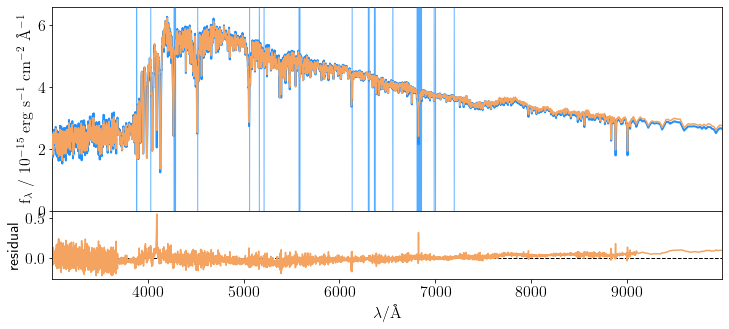

only recovered 1.0042064507246764 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374067055383154
posterior f_burst and t_burst: [0.09307032 0.09341996 0.09375027] [12.49648283 12.50488238 12.51361129]


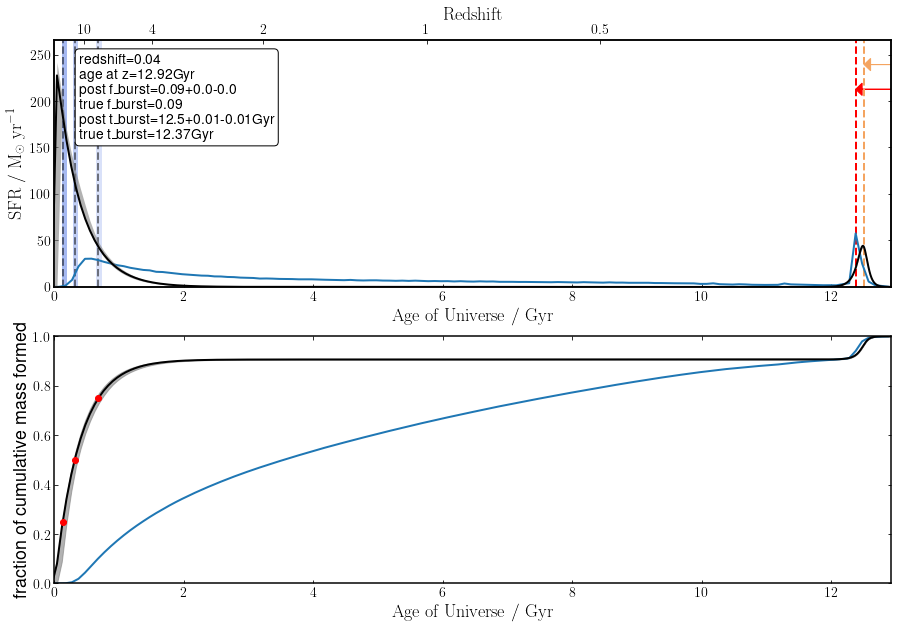

In [5]:
run_params_uZ_ndust_nnoise={}
run_params_uZ_ndust_nnoise['PSF'] = True
run_params_uZ_ndust_nnoise['dust'] = False
run_params_uZ_ndust_nnoise['noise'] = False
run_params_uZ_ndust_nnoise['spectrum_dir_root'] = '../Yirui_test_cube/snap119_uniformZ/'
run_params_uZ_ndust_nnoise['galID_parts'] = ['2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ','_SNR15']
run_params_uZ_ndust_nnoise['runID_parts'] = ['uniformZ', '_fixed_Mstar']
run_params_uZ_ndust_nnoise['Rspec'] = 4340
run_params_uZ_ndust_nnoise['bin_by'] = 1
z = 0.04
run_params_uZ_ndust_nnoise = process_params(run_params_uZ_ndust_nnoise)
run_params = run_params_uZ_ndust_nnoise.copy()

galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)
make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

Hmm not much luck, SFH is weird and bagpipes squished all star formation before the burst to super early times, with a very sharp decay timescale. What if we let Mstar to vary a little bit? i.e. log10Mstar = 11-11.04

setting bagpipes Rspec to 4340

Results loaded from pipes/posterior/uniformZ_no_dust_no_noise_bin_by_1_4340_Rspec_narrow_Mstar/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_SNR15.h5



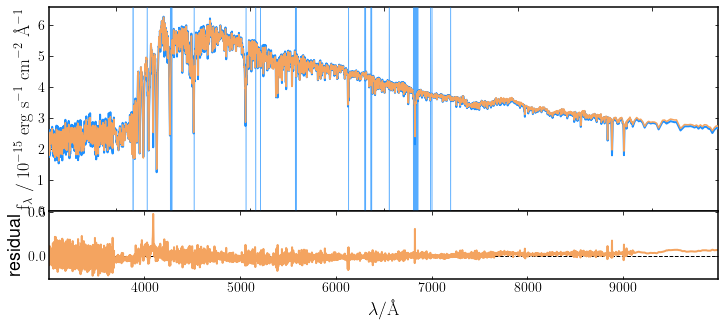

only recovered 0.7974112707448726 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374055761381662
posterior f_burst and t_burst: [0.10808959 0.10898161 0.10955537] [12.53266602 12.5396874  12.55030696]


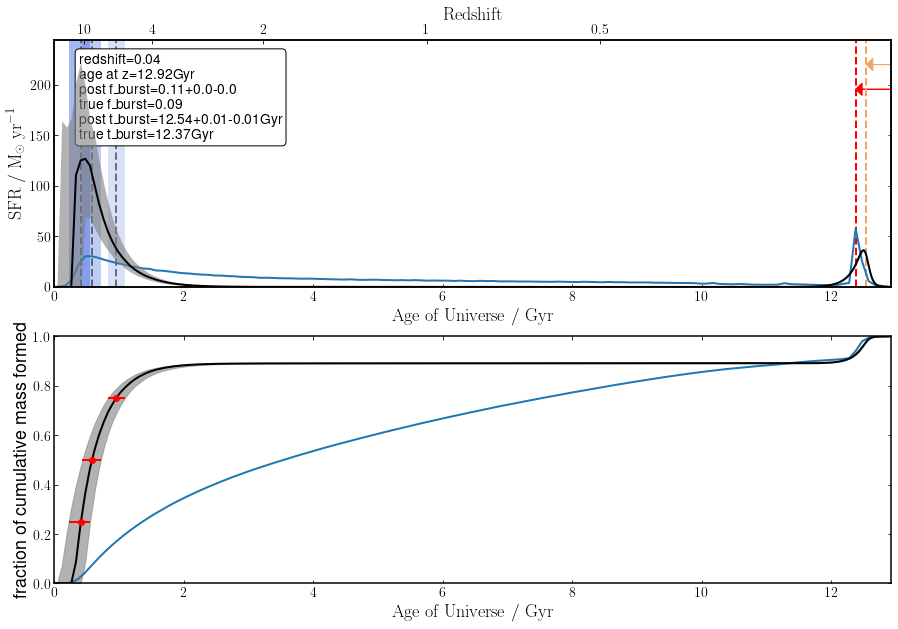

In [6]:
run_params_uZ_ndust_nnoise={}
run_params_uZ_ndust_nnoise['PSF'] = True
run_params_uZ_ndust_nnoise['dust'] = False
run_params_uZ_ndust_nnoise['noise'] = False
run_params_uZ_ndust_nnoise['spectrum_dir_root'] = '../Yirui_test_cube/snap119_uniformZ/'
run_params_uZ_ndust_nnoise['galID_parts'] = ['2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ','_SNR15']
run_params_uZ_ndust_nnoise['runID_parts'] = ['uniformZ', '_narrow_Mstar']
run_params_uZ_ndust_nnoise['Rspec'] = 4340
run_params_uZ_ndust_nnoise['bin_by'] = 1
z = 0.04
run_params_uZ_ndust_nnoise = process_params(run_params_uZ_ndust_nnoise)
run_params = run_params_uZ_ndust_nnoise.copy()

galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)
make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

Still very strange. I wonder if this has to do with potentially the metallicity of the uniformZ datacube not actually at solar metallicity? Now also letting metallicity run free (0.01-2.5 Zsun)

setting bagpipes Rspec to 4340

Results loaded from pipes/posterior/uniformZ_no_dust_no_noise_bin_by_1_4340_Rspec_narrow_Mstar_free_metallicity/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_no_dust_SNR15.h5



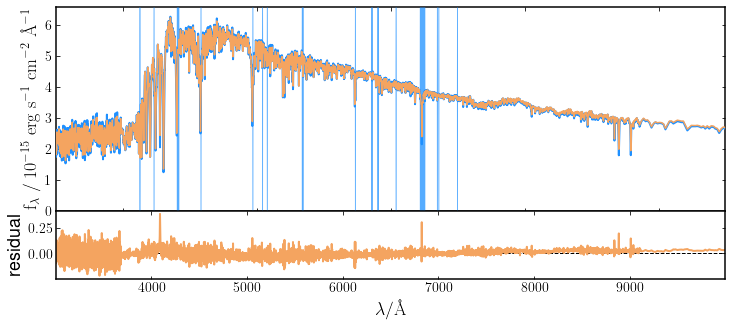

only recovered 0.8558674597990433 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.37407984936503
posterior f_burst and t_burst: [0.10187197 0.10322346 0.1044888 ] [12.37684266 12.38458552 12.39512367]


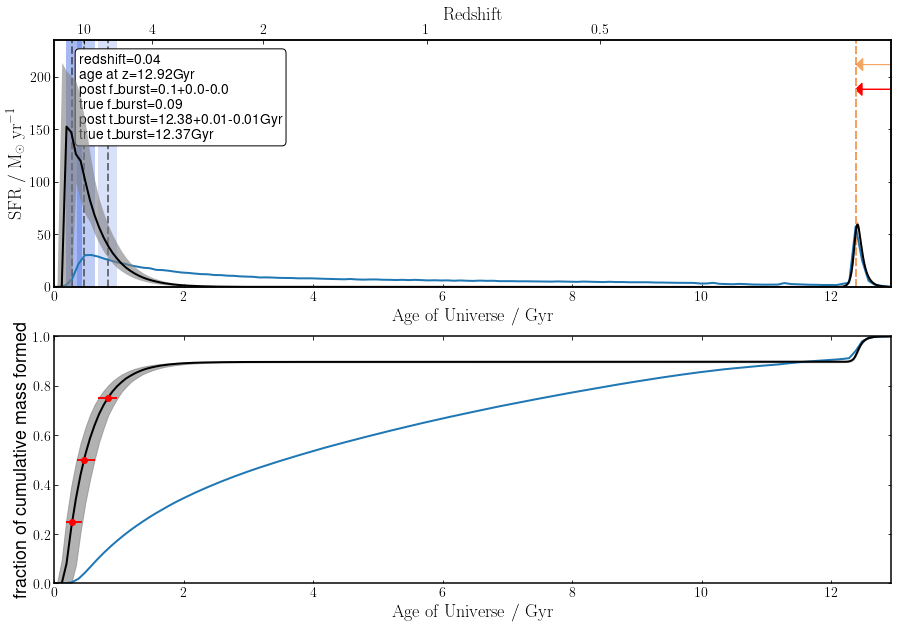

In [7]:
run_params_uZ_ndust_nnoise={}
run_params_uZ_ndust_nnoise['PSF'] = True
run_params_uZ_ndust_nnoise['dust'] = False
run_params_uZ_ndust_nnoise['noise'] = False
run_params_uZ_ndust_nnoise['spectrum_dir_root'] = '../Yirui_test_cube/snap119_uniformZ/'
run_params_uZ_ndust_nnoise['galID_parts'] = ['2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ','_SNR15']
run_params_uZ_ndust_nnoise['runID_parts'] = ['uniformZ', '_narrow_Mstar_free_metallicity']
run_params_uZ_ndust_nnoise['Rspec'] = 4340
run_params_uZ_ndust_nnoise['bin_by'] = 1
z = 0.04
run_params_uZ_ndust_nnoise = process_params(run_params_uZ_ndust_nnoise)
run_params = run_params_uZ_ndust_nnoise.copy()

galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)
make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

Not much luck, though the estimation of the SFH around the starburst seem to have improved. <br>
However, if we instead focus on the posterior fburst and tburst, we see that these values have dramatically improved. But can the same be said when dust is turned on?

setting bagpipes Rspec to 4340

Results loaded from pipes/posterior/uniformZ_with_dust_no_noise_bin_by_1_4340_Rspec_narrow_Mstar_free_metallicity/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ_with_PSF_with_dust_SNR15.h5



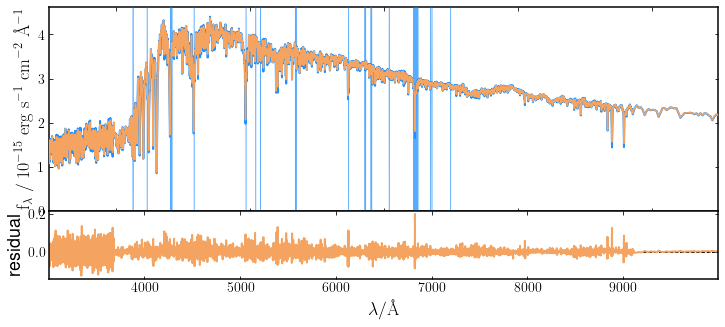

only recovered 0.9154816494855594 of total mass formed.
model f_burst and t_burst: 0.08993122012854099 12.374069160614557
posterior f_burst and t_burst: [0.1502277  0.16581242 0.18511603] [12.40216067 12.47071735 12.53369799]


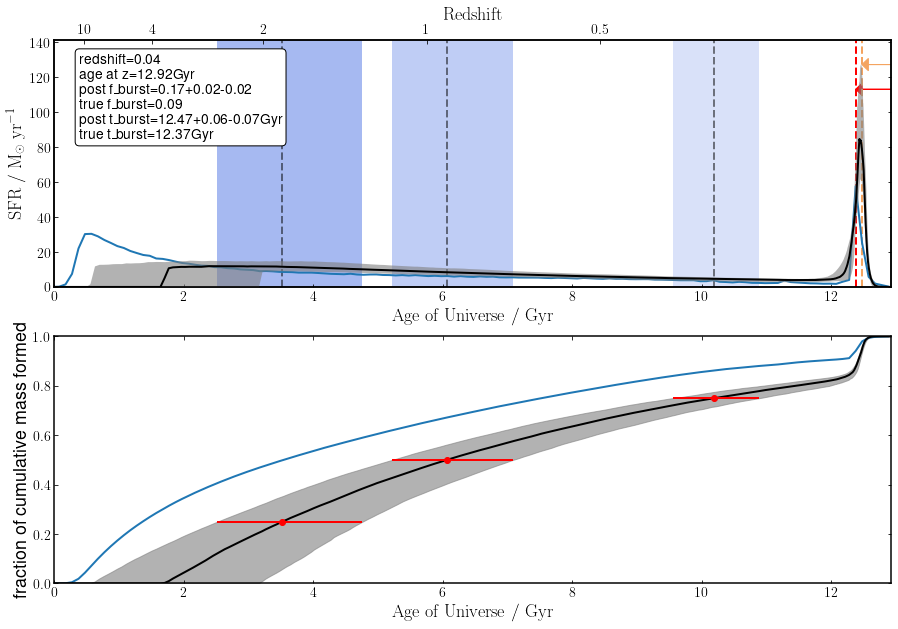

In [9]:
run_params_uZ_ndust_nnoise={}
run_params_uZ_ndust_nnoise['PSF'] = True
run_params_uZ_ndust_nnoise['dust'] = True
run_params_uZ_ndust_nnoise['noise'] = False
run_params_uZ_ndust_nnoise['spectrum_dir_root'] = '../Yirui_test_cube/snap119_uniformZ/'
run_params_uZ_ndust_nnoise['galID_parts'] = ['2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_uniformZ','_SNR15']
run_params_uZ_ndust_nnoise['runID_parts'] = ['uniformZ', '_narrow_Mstar_free_metallicity']
run_params_uZ_ndust_nnoise['Rspec'] = 4340
run_params_uZ_ndust_nnoise['bin_by'] = 1
z = 0.04
run_params_uZ_ndust_nnoise = process_params(run_params_uZ_ndust_nnoise)
run_params = run_params_uZ_ndust_nnoise.copy()

galaxy = pipes.galaxy(run_params['galID'], load_manga_spec_mask, photometry_exists=False)
make_plots(galaxy, run_params['galID'], run_params['runID'], model_ages, model_sfh)

And outshining is back! This is due to the dust-Mstar degeneracy that tends to inflate the Mstar and prevents a very accurate recovary of mass formed during the starburst.